In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram

In [2]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [50]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**10
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 1024
Range resolution 0.04
Range bin 0.010759043013010222
Max range 11.017260045322468


In [4]:
#read data
file_path = '../FMCW Radar/Rawdata/Rawdata_1.csv'
raw_data = readCsv(file_path)

In [41]:
RawData4Channel=np.array(raw_data).reshape(NUMBER_OF_CHANNEL,FRAME_COUNT,SAMPLE_PER_FRAME)

(4, 6000, 1024)
(4, 6000, 1024)


/var/folders/7_/v8dw7hn50j7dbqpv0scn2tv80000gn/T/ipykernel_17593/1534901975.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(411)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


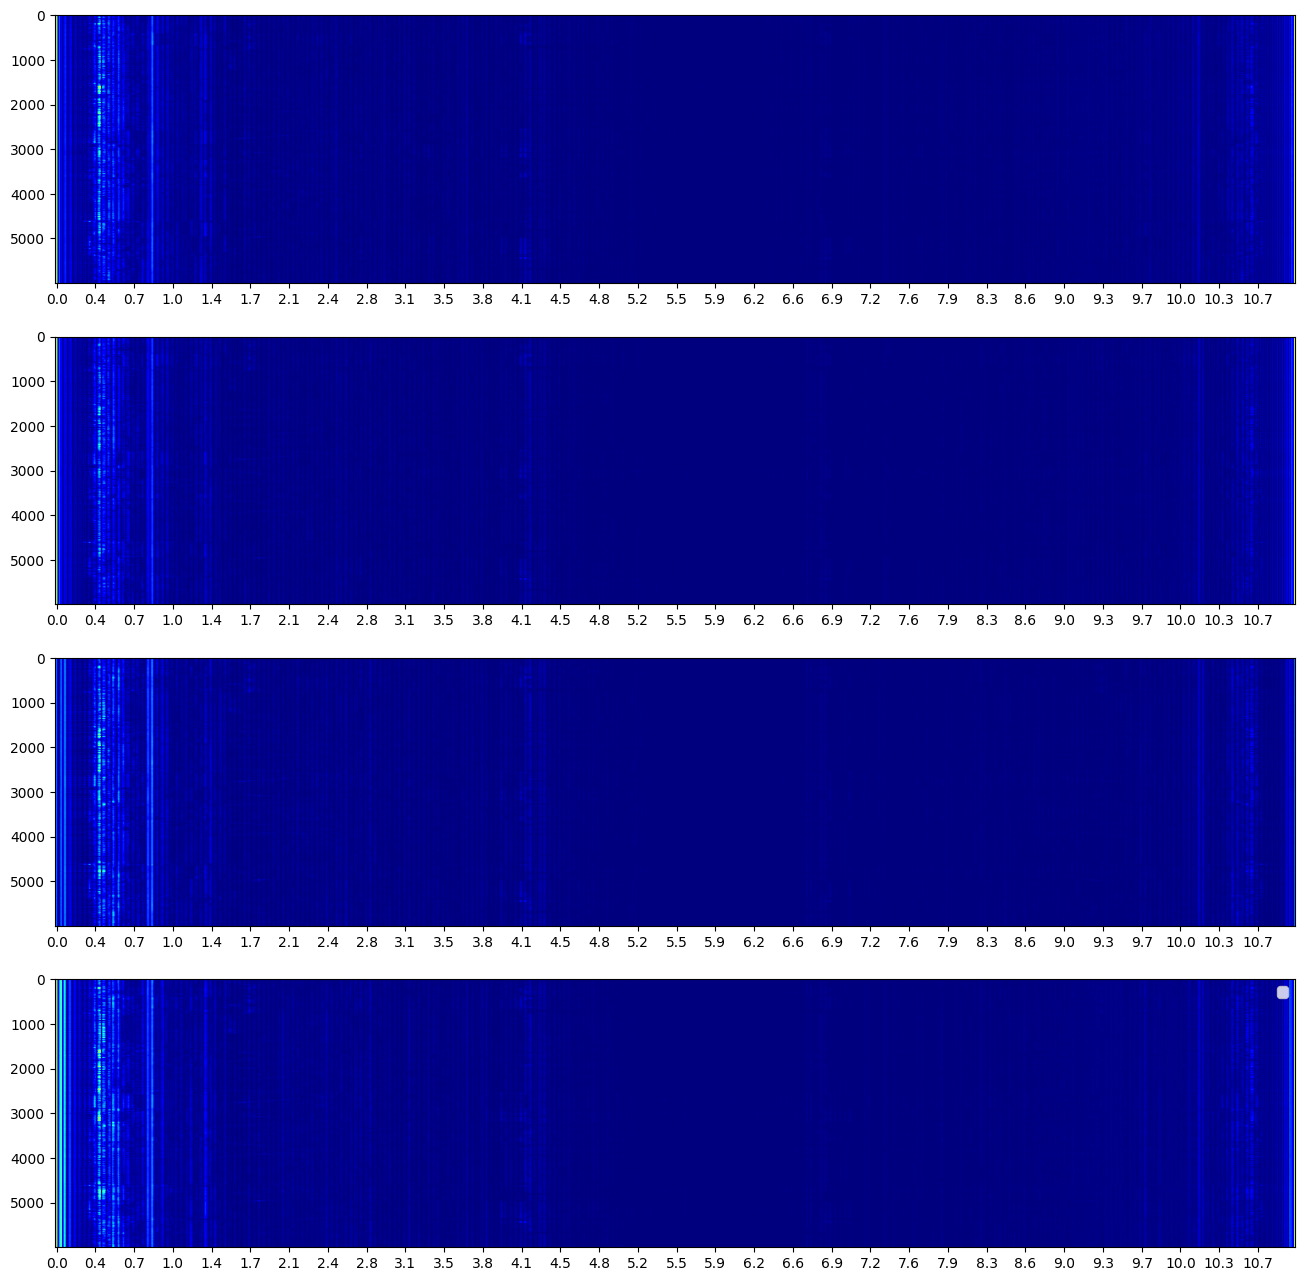

In [53]:
range_profile_matrixes =np.zeros((NUMBER_OF_CHANNEL,FRAME_COUNT,FFT_SIZE),dtype=complex)
print(range_profile_matrixes.shape)
for i in range(0,NUMBER_OF_CHANNEL):
    for j in range(0,FRAME_COUNT):
        range_profile_matrixes[i,j,:]=np.fft.fft(RawData4Channel[i,j,:],FFT_SIZE)
print(range_profile_matrixes.shape)

range_for_plotting =range(1,FFT_SIZE,2**5)
range_bin_distance =[round(j*RANGE_BIN,1) for j in range_for_plotting ]

plt.figure(figsize=(16,16))
plt.xlabel('Range')
plt.ylabel('Frame or time')
plt.title("Range time map")
plt.subplot(411)
plt.imshow(np.abs(range_profile_matrixes[0]),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.subplot(412)
plt.imshow(np.abs(range_profile_matrixes[1]),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.subplot(413)
plt.imshow(np.abs(range_profile_matrixes[2]),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.subplot(414)
plt.imshow(np.abs(range_profile_matrixes[3]),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.legend()
plt.show()


In [64]:
#MTI
alpha = 0.01
clutter_to_remove=np.zeros(((NUMBER_OF_CHANNEL,FRAME_COUNT,FFT_SIZE)),dtype=complex)
mti_output=np.zeros(((NUMBER_OF_CHANNEL,FRAME_COUNT,FFT_SIZE//2)),dtype=complex)
for ii in range(0,NUMBER_OF_CHANNEL):
    for jj in range(1,FRAME_COUNT):
        clutter_to_remove[ii,jj,:] =alpha * range_profile_matrixes[ii,jj,:] +(1-alpha)*clutter_to_remove[ii,jj-1,:]
        mti_output[ii,jj,:] =range_profile_matrixes[ii,jj,0:FFT_SIZE//2] -clutter_to_remove[ii,jj,0:FFT_SIZE//2]


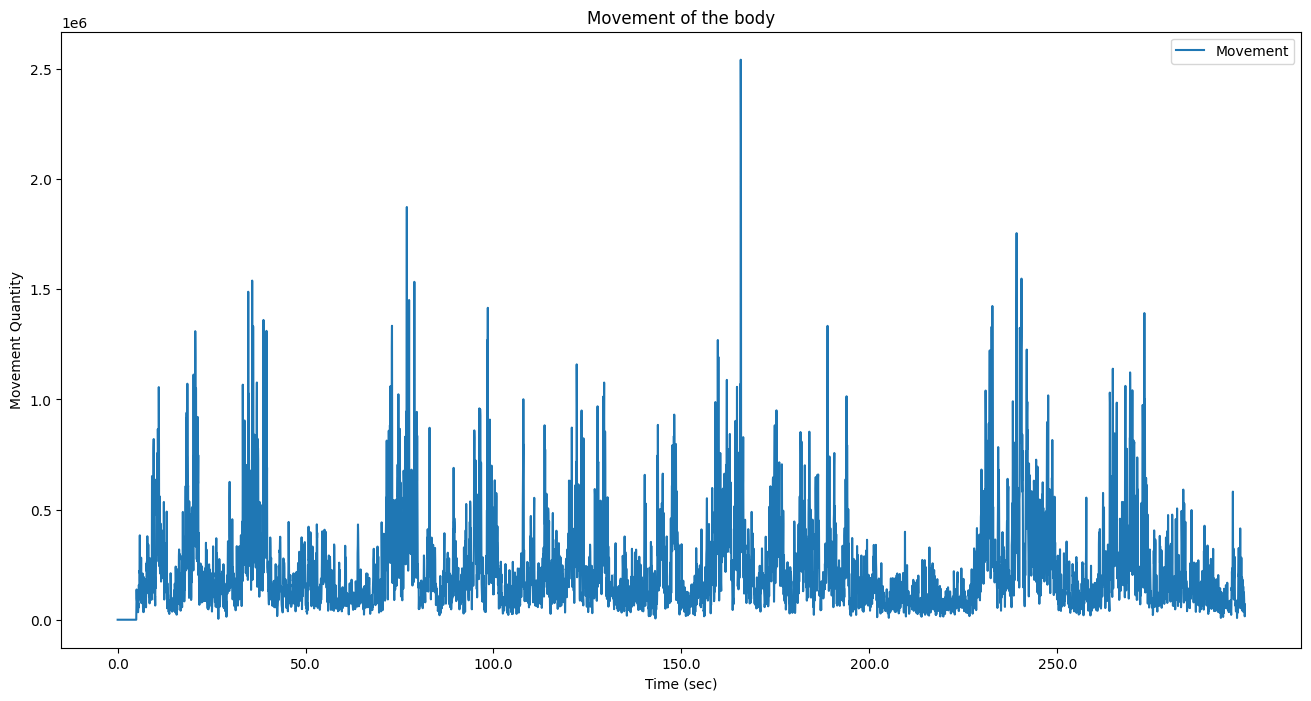

In [125]:
MTI_Sum_Rx_0= np.sum(np.abs(mti_output[0,:,:]),axis=1)
Movement_Rx_0 =np.abs(MTI_Sum_Rx_0[1:] - MTI_Sum_Rx_0[0:-1])
Movement_Rx_0=np.append(MTI_Sum_Rx_0[0],Movement_Rx_0)


MTI_Sum_Rx_1= np.sum(np.abs(mti_output[1,:,:]),axis=1)
Movement_Rx_1 =np.abs(MTI_Sum_Rx_1[1:] - MTI_Sum_Rx_1[0:-1])
Movement_Rx_1=np.append(MTI_Sum_Rx_1[0],Movement_Rx_1)


MTI_Sum_Rx_2= np.sum(np.abs(mti_output[2,:,:]),axis=1)
Movement_Rx_2 =np.abs(MTI_Sum_Rx_2[1:] - MTI_Sum_Rx_2[0:-1])
Movement_Rx_2=np.append(MTI_Sum_Rx_2[0],Movement_Rx_2)


MTI_Sum_Rx_3= np.sum(np.abs(mti_output[3,:,:]),axis=1)
Movement_Rx_3 =np.abs(MTI_Sum_Rx_3[1:] - MTI_Sum_Rx_3[0:-1])
Movement_Rx_3=np.append(MTI_Sum_Rx_3[0],Movement_Rx_3)

Total_Movement_Sum = Movement_Rx_0 + Movement_Rx_1 + Movement_Rx_2 + Movement_Rx_3 ;
Total_Movement_Sum[:100] = 0;
Total_MovementFlag = Total_Movement_Sum >= 850000;

plotting_range =range(0,len(Total_Movement_Sum),FPS*50)
xticks= [ xplt/FPS for xplt in plotting_range]

plt.figure(figsize=(16,8))
plt.title("Movement of the body")
plt.xlabel('Time (sec)');
plt.ylabel('Movement Quantity');
plt.plot(Total_Movement_Sum,label="Movement")
plt.xticks(plotting_range,xticks)
plt.legend()
plt.show()